# Data analysis of WeRateDogs Twitter account. 

In [80]:
import pandas as pd
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
import tweepy
import json
import re
from tweepy import OAuthHandler
from timeit import default_timer as timer
from functools import reduce

## 1. Gather data

#### 1. The WeRateDogs Twitter archive

In [2]:
#importing csv file
df_1 = pd.read_csv("twitter-archive-enhanced.csv")
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
#getting some information about dataframe
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### 2. The tweet image predictions

In [3]:
#getting the file of Image predictions programatically
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = rq.get(url)

with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

In [4]:
#reading the downloaded file
image_p = pd.read_csv('image-predictions.tsv', sep = '\t')

In [5]:
#Retrieving some info
image_p.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 3. Twitter API

In [77]:
# I took this code from my udacity class rooom. Because I could not get the Twitter API token.
#https://classroom.udacity.com/nanodegrees/nd002-ent/parts/f55ce890-c08c-46a5-b57f-55a06c1cc6ae/modules/a8fcd18c-b9a5-4852-a7ec-6dbb08ebfe5a/lessons/a8085857-3e28-4fc7-aeb8-da64ccbc2e20/concepts/d7e3de1b-d7a1-4ebc-9d58-beba021a7c29


# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

Fail
288: 838561493054533637
Fail
289: 838476387338051585
Fail
290: 838201503651401729
Fail
291: 838150277551247360
Fail
292: 838085839343206401
Fail
293: 838083903487373313
Fail
294: 837820167694528512
Fail
295: 837482249356513284
Fail
296: 837471256429613056
Fail
297: 837366284874571778
Fail
298: 837110210464448512
Fail
299: 837012587749474308
Fail
300: 836989968035819520
Fail
301: 836753516572119041
Fail
302: 836677758902222849
Fail
303: 836648853927522308
Fail
304: 836397794269200385
Fail
305: 836380477523124226
Fail
306: 836260088725786625
Fail
307: 836001077879255040
Fail
308: 835685285446955009
Fail
309: 835574547218894849
Fail
310: 835536468978302976
Fail
311: 835309094223372289
Fail
312: 835297930240217089
Fail
313: 835264098648616962
Fail
314: 835246439529840640
Fail
315: 835172783151792128
Fail
316: 835152434251116546
Fail
317: 834931633769889797
Fail
318: 834786237630337024
Fail
319: 834574053763584002
Fail
320: 834477809192075265
Fail
321: 834458053273591808
Fail
322: 8342

Fail
571: 801854953262350336
Fail
572: 801538201127157760
Fail
573: 801285448605831168
Fail
574: 801167903437357056
Fail
575: 801127390143516673
Fail
576: 801115127852503040
Fail
577: 800859414831898624
Fail
578: 800855607700029440
Fail
579: 800751577355128832
Fail
580: 800513324630806528
Fail
581: 800459316964663297
Fail
582: 800443802682937345
Fail
583: 800388270626521089
Fail
584: 800188575492947969
Fail
585: 800141422401830912
Fail
586: 800018252395122689
Fail
587: 799774291445383169
Fail
588: 799757965289017345
Fail
589: 799422933579902976
Fail
590: 799308762079035393
Fail
591: 799297110730567681
Fail
592: 799063482566066176
Fail
593: 798933969379225600
Fail
594: 798925684722855936
Fail
595: 798705661114773508
Fail
596: 798701998996647937
Fail
597: 798697898615730177
Fail
598: 798694562394996736
Fail
599: 798686750113755136
Fail
600: 798682547630837760
Fail
601: 798673117451325440
Fail
602: 798665375516884993
Fail
603: 798644042770751489
Fail
604: 798628517273620480
Fail
605: 7985

Fail
854: 765371061932261376
Fail
855: 765222098633691136
Fail
856: 764857477905154048
Fail
857: 764259802650378240
Fail
858: 763956972077010945
Fail
859: 763837565564780549
Fail
860: 763183847194451968
Fail
861: 763167063695355904
Fail
862: 763103485927849985
Fail
863: 762699858130116608
Fail
864: 762471784394268675
Fail
865: 762464539388485633
Fail
866: 762316489655476224
Fail
867: 762035686371364864
Fail
868: 761976711479193600
Fail
869: 761750502866649088
Fail
870: 761745352076779520
Fail
871: 761672994376806400
Fail
872: 761599872357261312
Fail
873: 761371037149827077
Fail
874: 761334018830917632
Fail
875: 761292947749015552
Fail
876: 761227390836215808
Fail
877: 761004547850530816
Fail
878: 760893934457552897
Fail
879: 760656994973933572
Fail
880: 760641137271070720
Fail
881: 760539183865880579
Fail
882: 760521673607086080
Fail
883: 760290219849637889
Fail
884: 760252756032651264
Fail
885: 760190180481531904
Fail
886: 760153949710192640
Fail
887: 759943073749200896
Fail
888: 7599

Fail
1132: 728986383096946689
Fail
1133: 728760639972315136
Fail
1134: 728751179681943552
Fail
1135: 728653952833728512
Fail
1136: 728409960103686147
Fail
1137: 728387165835677696
Fail
1138: 728046963732717569
Fail
1139: 728035342121635841
Fail
1140: 728015554473250816
Fail
1141: 727685679342333952
Fail
1142: 727644517743104000
Fail
1143: 727524757080539137
Fail
1144: 727314416056803329
Fail
1145: 727286334147182592
Fail
1146: 727175381690781696
Fail
1147: 727155742655025152
Fail
1148: 726935089318363137
Fail
1149: 726887082820554753
Fail
1150: 726828223124897792
Fail
1151: 726224900189511680
Fail
1152: 725842289046749185
Fail
1153: 725786712245440512
Fail
1154: 725729321944506368
Fail
1155: 725458796924002305
Fail
1156: 724983749226668032
Fail
1157: 724771698126512129
Fail
1158: 724405726123311104
Fail
1159: 724049859469295616
Fail
1160: 724046343203856385
Fail
1161: 724004602748780546
Fail
1162: 723912936180330496
Fail
1163: 723688335806480385
Fail
1164: 723673163800948736
Fail
1165:

Fail
1406: 699323444782047232
Fail
1407: 699088579889332224
Fail
1408: 699079609774645248
Fail
1409: 699072405256409088
Fail
1410: 699060279947165696
Fail
1411: 699036661657767936
Fail
1412: 698989035503689728
Fail
1413: 698953797952008193
Fail
1414: 698907974262222848
Fail
1415: 698710712454139905
Fail
1416: 698703483621523456
Fail
1417: 698635131305795584
Fail
1418: 698549713696649216
Fail
1419: 698355670425473025
Fail
1420: 698342080612007937
Fail
1421: 698262614669991936
Fail
1422: 698195409219559425
Fail
1423: 698178924120031232
Fail
1424: 697995514407682048
Fail
1425: 697990423684476929
Fail
1426: 697943111201378304
Fail
1427: 697881462549430272
Fail
1428: 697630435728322560
Fail
1429: 697616773278015490
Fail
1430: 697596423848730625
Fail
1431: 697575480820686848
Fail
1432: 697516214579523584
Fail
1433: 697482927769255936
Fail
1434: 697463031882764288
Fail
1435: 697270446429966336
Fail
1436: 697259378236399616
Fail
1437: 697255105972801536
Fail
1438: 697242256848379904
Fail
1439:

Fail
1680: 682032003584274432
Fail
1681: 682003177596559360
Fail
1682: 681981167097122816
Fail
1683: 681891461017812993
Fail
1684: 681694085539872773
Fail
1685: 681679526984871937
Fail
1686: 681654059175129088
Fail
1687: 681610798867845120
Fail
1688: 681579835668455424
Fail
1689: 681523177663676416
Fail
1690: 681340665377193984
Fail
1691: 681339448655802368
Fail
1692: 681320187870711809
Fail
1693: 681302363064414209
Fail
1694: 681297372102656000
Fail
1695: 681281657291280384
Fail
1696: 681261549936340994
Fail
1697: 681242418453299201
Fail
1698: 681231109724700672
Fail
1699: 681193455364796417
Fail
1700: 680970795137544192
Fail
1701: 680959110691590145
Fail
1702: 680940246314430465
Fail
1703: 680934982542561280
Fail
1704: 680913438424612864
Fail
1705: 680889648562991104
Fail
1706: 680836378243002368
Fail
1707: 680805554198020098
Fail
1708: 680801747103793152
Fail
1709: 680798457301471234
Fail
1710: 680609293079592961
Fail
1711: 680583894916304897
Fail
1712: 680497766108381184
Fail
1713:

Fail
1954: 673662677122719744
Fail
1955: 673656262056419329
Fail
1956: 673636718965334016
Fail
1957: 673612854080196609
Fail
1958: 673583129559498752
Fail
1959: 673580926094458881
Fail
1960: 673576835670777856
Fail
1961: 673363615379013632
Fail
1962: 673359818736984064
Fail
1963: 673355879178194945
Fail
1964: 673352124999274496
Fail
1965: 673350198937153538
Fail
1966: 673345638550134785
Fail
1967: 673343217010679808
Fail
1968: 673342308415348736
Fail
1969: 673320132811366400
Fail
1970: 673317986296586240
Fail
1971: 673295268553605120
Fail
1972: 673270968295534593
Fail
1973: 673240798075449344
Fail
1974: 673213039743795200
Fail
1975: 673148804208660480
Fail
1976: 672997845381865473
Fail
1977: 672995267319328768
Fail
1978: 672988786805112832
Fail
1979: 672984142909456390
Fail
1980: 672980819271634944
Fail
1981: 672975131468300288
Fail
1982: 672970152493887488
Fail
1983: 672968025906282496
Fail
1984: 672964561327235073
Fail
1985: 672902681409806336
Fail
1986: 672898206762672129
Fail
1987:

Fail
2228: 668268907921326080
Fail
2229: 668256321989451776
Fail
2230: 668248472370458624
Fail
2231: 668237644992782336
Fail
2232: 668226093875376128
Fail
2233: 668221241640230912
Fail
2234: 668204964695683073
Fail
2235: 668190681446379520
Fail
2236: 668171859951755264
Fail
2237: 668154635664932864
Fail
2238: 668142349051129856
Fail
2239: 668113020489474048
Fail
2240: 667937095915278337
Fail
2241: 667924896115245057
Fail
2242: 667915453470232577
Fail
2243: 667911425562669056
Fail
2244: 667902449697558528
Fail
2245: 667886921285246976
Fail
2246: 667885044254572545
Fail
2247: 667878741721415682
Fail
2248: 667873844930215936
Fail
2249: 667866724293877760
Fail
2250: 667861340749471744
Fail
2251: 667832474953625600
Fail
2252: 667806454573760512
Fail
2253: 667801013445750784
Fail
2254: 667793409583771648
Fail
2255: 667782464991965184
Fail
2256: 667773195014021121
Fail
2257: 667766675769573376
Fail
2258: 667728196545200128
Fail
2259: 667724302356258817
Fail
2260: 667550904950915073
Fail
2261:

Looks like the tokens are expired. Thus I downloaded the file called 'tweet-json.txt' from my classroom via abovementioned link. 

In [6]:
#Extracting the important columns of Json text file. Afterwards I am putting the coulmns into pandas Dataframe so 
#that I can see and assess the data.
my_list = []
with open('tweet-json.txt', encoding = 'utf-8') as file_json:
    for each in file_json:
        json_d = json.loads(each)
        tweet_id = json_d['id']
        favorite_count = json_d['favorite_count']
        retweet_count = json_d['retweet_count']

        my_list.append({'tweet_id': tweet_id,
                        'favorite_count': favorite_count,
                        'retweet_count': retweet_count,
                        })
        
tweet_json = pd.DataFrame(my_list, columns = ['tweet_id', 'favorite_count', 'retweet_count'])


In [8]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   favorite_count  2354 non-null   int64
 2   retweet_count   2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [7]:
tweet_json.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


## 2. Assess the data

### Let us assess first the Twitter archive data

In [11]:
# Gives 10 random samples of dataframe
df_1.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1226,713919462244790272,NaN,NaN,2016-03-27 02:43:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kanu. He's a Freckled Ticonderoga. Sim...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713919462...,12,10,Kanu,None,None,None,None
1585,686947101016735744,NaN,NaN,2016-01-12 16:25:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jackson. He was specifically told not ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686947101...,11,10,Jackson,None,None,None,None
664,790723298204217344,NaN,NaN,2016-10-25 01:14:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Happy. He's a bathtub r...,7.899865e+17,4.196984e+09,2016-10-23 00:27:05 +0000,https://twitter.com/dog_rates/status/789986466...,12,10,Happy,None,None,None,None
1525,690400367696297985,NaN,NaN,2016-01-22 05:07:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Eriq. His friend just reminded him of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690400367...,10,10,Eriq,None,None,None,None
1278,708853462201716736,NaN,NaN,2016-03-13 03:13:29 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Lucy. She doesn't understand fetch. 8/...,NaN,NaN,NaN,https://vine.co/v/iHl2UDEBZ95,8,10,Lucy,None,None,None,None
362,829449946868879360,NaN,NaN,2017-02-08 22:00:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a stressed doggo. Had a long day. Many ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/829449946...,11,10,None,doggo,None,None,None
2254,667782464991965184,NaN,NaN,2015-11-20 19:12:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Super rare dog. Endangered (?). Thinks it's fu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667782464...,9,10,None,None,None,None,None
1718,680176173301628928,NaN,NaN,2015-12-25 00:00:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper is patiently waiting to scare the ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680176173...,10,10,None,None,None,pupper,None
1376,701805642395348998,NaN,NaN,2016-02-22 16:27:58 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Please pray for this pupper. Nothing wrong wit...,NaN,NaN,NaN,https://vine.co/v/ivV6Y37mH5Z,11,10,None,None,None,pupper,None
616,796484825502875648,NaN,NaN,2016-11-09 22:49:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a sleepy doggo that requested some assi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/796484825...,12,10,None,doggo,None,None,None


#### As you can see there are some numbers in retweeted_status_id and retweeted_status_user_id instead of NaNs. This means this data has retweets.

In [12]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### Timestamp is string. 

#### retweeted_status_timestamp is string.

In [13]:
#Series containing counts of unique values
df_1.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

#### Source column has html tags.

In [14]:
#I have viewed visually also by excell. So I can see name column fully.
df_1.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           a
2353           a
2354           a
2355        None
Name: name, Length: 2356, dtype: object

In [15]:
# Selecting name = a OR name = None
df_1[(df_1['name'] == 'a') | (df_1['name'] == 'None')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


#### name column has None instead of NaN.

In [52]:
df_1.name.sample(30)

2290     Kenneth
848         Juno
8           Zoey
215        Snoop
728       Harper
1234        None
854       Gromit
1248        None
1816        None
574       Anakin
652         BeBe
818         None
2296       Clybe
369          one
611         None
1900      Rodman
1769     Crumpet
54          Gary
1051        None
1761        None
1955           a
1573        Marq
1834        None
375         None
405         Cash
346         None
2050         Pip
117     Clifford
2164     Oliviér
1306        None
Name: name, dtype: object

In [53]:
#When sampling multiple times I have seen name called O. Selecting name = O
df_1[df_1['name'] == 'O']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
775,776201521193218049,NaN,NaN,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776201521...,10,10,O,None,None,None,None


#### There a lot of inaccurute names in this dataframe such as a, an, such, the, by, very, O and so on.

In [54]:
df_1.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [55]:
df_1.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [56]:
df_1.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [57]:
df_1.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

#### Ok these four columns have None values instead of NaN.

In [58]:
# Seeking for upper case values of name column.
df_1.loc[df_1['name'].str.isupper()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
775,776201521193218049,NaN,NaN,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776201521...,10,10,O,None,None,None,None
2041,671542985629241344,NaN,NaN,2015-12-01 04:14:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is JD (stands for ""just dog""). He's like ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/671542985...,10,10,JD,None,None,None,None


#### There is a JD name also. What a name :( . Ok So I will replace them with O'Malley and Just Dog.

In [43]:
#Let see the data tyoe of tweet_id column.
df_1.tweet_id.value_counts()

749075273010798592    1
741099773336379392    1
798644042770751489    1
825120256414846976    1
769212283578875904    1
                     ..
715360349751484417    1
666817836334096384    1
794926597468000259    1
673705679337693185    1
700151421916807169    1
Name: tweet_id, Length: 2356, dtype: int64

#### Ok I will change tweet_id also. This one should be a string since we are not doing any calculations on it. 

In [59]:
df_1.rating_numerator.sample(30)

457     11
784      9
1353    10
1865    13
1066     8
1672     9
975     13
2247    10
1736     8
360     12
1651    11
1570    11
560     12
1446     1
268     14
914     10
59      12
1847    11
1500    10
494     13
1376    11
1726    10
18      13
674     12
1005    12
389     12
1942    10
2130     9
215     13
1815    12
Name: rating_numerator, dtype: int64

In [84]:
df_1.rating_denominator.sample(30)

2211    10
1387    10
1522    10
2006    10
61      10
164     10
215     10
912     10
163     10
307     10
2303    10
827     10
621     10
126     10
1200    10
449     10
1692    10
118     10
1449    10
1592    10
1758    10
1689    10
1739    10
1667    10
1399    10
2168    10
419     10
1228    90
2017    10
892     10
Name: rating_denominator, dtype: int64

In [85]:
df_1[df_1['rating_denominator'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


#### This is weird. Denominator cannot be 0. Whereas numerator is 960. Ok this is going to be fun :)

### Second I go with Image predictions data.

In [26]:
image_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### There are 2075 rows. Whereas in df_1 dataframe, there are 2356. This means whether there are some missing data or some tweets do not have images. 

In [86]:
image_p.jpg_url.value_counts()

https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg                                            2
https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg                                            2
https://pbs.twimg.com/media/CvaYgDOWgAEfjls.jpg                                            2
https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg                                            2
https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg                                            2
                                                                                          ..
https://pbs.twimg.com/ext_tw_video_thumb/685663358637486080/pu/img/3cXSHFZAgJQ_dDCf.jpg    1
https://pbs.twimg.com/media/C8hwNxbXYAAwyVG.jpg                                            1
https://pbs.twimg.com/media/CgxUTS_XEAAC0pv.jpg                                            1
https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg                                            1
https://pbs.twimg.com/media/CUbrDWOWcAEyMdM.jpg                       

In [87]:
image_p.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [88]:
image_p.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
revolver                1
ibex                    1
sunglasses              1
school_bus              1
electric_fan            1
Name: p1, Length: 378, dtype: int64

In [89]:
image_p.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
mud_turtle              1
apron                   1
space_heater            1
spatula                 1
streetcar               1
Name: p2, Length: 405, dtype: int64

In [90]:
image_p.p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
bullfrog               1
valley                 1
soccer_ball            1
moped                  1
boathouse              1
Name: p3, Length: 408, dtype: int64

#### Here we go. You see the underscores of p1, p2 and p3. In addition, I will create two columns called dog breeds and prediction confidence based on these p columns.

In [91]:
image_p.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Third is tweet_json dataframe from Twitter API

In [92]:
#Let us take some samples
tweet_json.sample(10)

,tweet_id,favorite_count,retweet_count
1338,704859558691414016,2462,612
1822,676496375194980353,1641,602
2172,669216679721873412,958,422
1358,703268521220972544,2152,618
1602,685906723014619143,8277,3303
912,757393109802180609,6462,2009
993,748346686624440324,5735,1413
1041,743835915802583040,0,2387
1669,682393905736888321,2441,773
1349,704054845121142784,3201,1028


In [93]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   favorite_count  2354 non-null   int64
 2   retweet_count   2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [94]:
tweet_json.tweet_id.value_counts()

749075273010798592    1
741099773336379392    1
798644042770751489    1
825120256414846976    1
769212283578875904    1
                     ..
794926597468000259    1
673705679337693185    1
673342308415348736    1
754482103782404096    1
700151421916807169    1
Name: tweet_id, Length: 2354, dtype: int64

In [95]:
tweet_json.favorite_count.value_counts()

0        179
610        3
345        3
2918       3
1691       3
        ... 
33345      1
814        1
23108      1
2630       1
8143       1
Name: favorite_count, Length: 2007, dtype: int64

In [96]:
tweet_json.retweet_count.value_counts()

1972     5
3652     5
83       5
146      4
61       4
        ..
8209     1
19       1
2068     1
30742    1
0        1
Name: retweet_count, Length: 1724, dtype: int64

### Quality issues:

#### df_1 DataFrame
- Data has retweets since there are some numbers in retweeted_status_id and retweeted_status_user_id instead of NaNs. 
- timestamp column is string type.
- source column has html tags with some text.
- name column contains values such as string "None".
- name column has awkward names such as a, an, such, the, by, very and so on.
- name column has O, JD. It should O'Malley and Just Dog.
- tweet_id is integer. It should be string since there are not any calculations.
- Wrong data in rating numerator and rating denominator column since tweets include more than one rating or decimal numbers. 
- Fraction for rating numerator and rating denominator.

#### image_p DataFrame

- Remove underscores and make them lowercase of p1, p2 and p3.

### Tideness issues:

#### df_1 DataFrame
- 4 different names such as doggo, floofer, pupper, puppo. Change name to dog type. 

#### tweet_json DataFrame

- Combine tweet_json with df_1 since data are related to each other. 

#### image_p DataFrame

- Combine image_p with df_1 since data of image_p is related to df_1.
- Create dog breeds and prediction confidence columns by p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog. Drop the p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog.

## 3. Clean the data

In [8]:
#Copy the data to a new variable. So we can work safely with copied variable.
df_1_copied = df_1.copy()
tweet_json_copied = tweet_json.copy()
image_p_copied = image_p.copy()

## Tidiness:
Firstly, I will start cleaning with Tidiness issues since they are more important for beginning. I will solve these two issues since first tidiness issue will be more easy to clean by solving these two issues.
## Define:
- Combine tweet_json with df_1 since data are kinda same.
- Combine image_p with df_1 since data of image_p is related to df_1.
### Solving: Merge dataFrames on tweet_id column.

## Code: 

In [9]:
#I will merge these three DataFrames on tweet_id column.
#I will make some list first.
df_3 = [df_1_copied, tweet_json_copied, image_p_copied]

#I will use lambda for merging. I will use reduce funtion.
#https://stackoverflow.com/questions/8689184/nameerror-name-reduce-is-not-defined-in-python
twitter_full = reduce(lambda left, right: pd.merge(left, right, on = 'tweet_id'), df_3)


## Test:

In [10]:
twitter_full.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [11]:
#There should be 30 columns.
twitter_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  doggo                       2073 

## Define: 
- 4 different names such as doggo, floofer, pupper, puppo. Change name to dog type.
### Solving: Take the dog types from text column and drop the doggo, floofer, pupper, puppo. I will use ReGex(regular expression). 

## Code:

In [12]:
#creating new column called dog_type. Extracting doggo, floofer, pupper, puppo from text column. 
#https://stackoverflow.com/questions/54343378/pandas-valueerror-pattern-contains-no-capture-groups
twitter_full['dog_type'] = twitter_full['text'].str.extract('(doggo|floofer|pupper|puppo)')

In [13]:
#Viewing the new column called dog type
twitter_full[['dog_type', 'doggo', 'floofer', 'pupper', 'puppo']].head(10)

,dog_type,doggo,floofer,pupper,puppo
0,NaN,None,None,None,None
1,NaN,None,None,None,None
2,NaN,None,None,None,None
3,NaN,None,None,None,None
4,NaN,None,None,None,None
5,NaN,None,None,None,None
6,NaN,None,None,None,None
7,NaN,None,None,None,None
8,NaN,None,None,None,None
9,doggo,doggo,None,None,None


In [14]:
#Drop the doggo, floofer, pupper, puppo.
twitter_full = twitter_full.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

## Test:

In [15]:
#There should be 27 columns
twitter_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  favorite_count              2073 

## Define: 
- Create dog breeds and prediction confidence columns by p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog. Drop the p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog. 
### Solving: If the first prediction was not the dog breed then take the second and so on.  

## Code:

In [16]:
#writing a funtion which extracts dog breeds from the columns.
def dog_breed(row):
    if row['p1_dog']:
        return(row['p1'])
    elif row['p2_dog']:
        return(row['p2'])
    elif row['p3_dog']:
        return(row['p3'])
    else:
        return(np.NaN)

In [17]:
#creating new column called dog_breed and applying it into the dataframe.
twitter_full['dog_breed'] = twitter_full.apply(lambda row: dog_breed(row), axis = 1)

In [18]:
#writing a funtion which extracts prediction confidence from the columns.
def pred_conf(row):
    if row['p1_dog']:
        return(row['p1_conf'])
    elif row['p2_dog']:
        return(row['p2_conf'])
    elif row['p3_dog']:
        return(row['p3_conf'])
    else:
        return(np.NaN)

In [19]:
#creating new column called pred_confidence and applying it into the dataframe.
twitter_full['pred_confidence'] = twitter_full.apply(lambda row: pred_conf(row), axis = 1)

In [20]:
#Drop the p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog.
twitter_full = twitter_full.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis = 1)

## Test:

In [21]:
twitter_full.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,img_num,dog_type,dog_breed,pred_confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,39467,8853,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,33819,6514,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,NaN,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,25461,4328,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,NaN,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,42908,8964,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,NaN,Labrador_retriever,0.168086
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,41048,9774,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,NaN,basset,0.555712


In [22]:
#There should be 20 columns
twitter_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  favorite_count              2073 

## Quality:
## Define:
- Data has retweets since there are some numbers in retweeted_status_id and retweeted_status_user_id instead of NaNs.
### Solving: Keep the rows where retweeted_status_id has NaN values. Drop the retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.

## Code:

In [23]:
#Keping the NaNs.
twitter_full = twitter_full[np.isnan(twitter_full.retweeted_status_id)]
twitter_full.retweeted_status_id

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2068   NaN
2069   NaN
2070   NaN
2071   NaN
2072   NaN
Name: retweeted_status_id, Length: 1994, dtype: float64

In [24]:
#Dropping retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp
twitter_full = twitter_full.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1)

## Test:

In [25]:
#There should be 17 columns
twitter_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1994 non-null   int64  
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              1994 non-null   object 
 4   source                 1994 non-null   object 
 5   text                   1994 non-null   object 
 6   expanded_urls          1994 non-null   object 
 7   rating_numerator       1994 non-null   int64  
 8   rating_denominator     1994 non-null   int64  
 9   name                   1994 non-null   object 
 10  favorite_count         1994 non-null   int64  
 11  retweet_count          1994 non-null   int64  
 12  jpg_url                1994 non-null   object 
 13  img_num                1994 non-null   int64  
 14  dog_type               326 non-null    object 
 15  dog_

## Define:
- timestamp column is string type.
### Solving: Convert it into datetime data type.

## Code:

In [26]:
#Get rid of the time zone info from timestamp column
twitter_full['timestamp'] = twitter_full['timestamp'].str.slice(start = 0, stop = -6)

In [27]:
#Convert it into datetime data type
twitter_full['timestamp'] = pd.to_datetime(twitter_full['timestamp'], format = '%Y-%m-%d %H:%M:%S')

## Test:

In [28]:
#Check the timestamp data type
twitter_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1994 non-null   int64         
 1   in_reply_to_status_id  23 non-null     float64       
 2   in_reply_to_user_id    23 non-null     float64       
 3   timestamp              1994 non-null   datetime64[ns]
 4   source                 1994 non-null   object        
 5   text                   1994 non-null   object        
 6   expanded_urls          1994 non-null   object        
 7   rating_numerator       1994 non-null   int64         
 8   rating_denominator     1994 non-null   int64         
 9   name                   1994 non-null   object        
 10  favorite_count         1994 non-null   int64         
 11  retweet_count          1994 non-null   int64         
 12  jpg_url                1994 non-null   object        
 13  img

## Define:
- source column has html tags with some text.
### Solving: Remove the html tags and only leave the name of device.

## Code:

In [29]:
twitter_full.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1955
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [30]:
#Extracting the only the name. I am using the awesome ReGex.
twitter_full['source'] = twitter_full['source'].str.extract('(Twitter for iPhone|Twitter Web Client|TweetDeck)')

## Test:

In [31]:
twitter_full.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

## Define:
- name column contains values such as string "None".
- name column has awkward names such as a, an, such, the, by, very, O, JD and so on.
- name column has O, JD. It should O'Malley and Just Dog.
### Solving: Replace all with NaN where you see some weird names. Replace O with O'Malley and JD with Just Dog. 

## Code:

In [32]:
#Let us find the lowercase values. Maybe there are lots of weird names
lower_name =  []
for i in twitter_full.name:
    if i[0].islower() and i not in lower_name:
        lower_name.append(i)
print(lower_name)

['such', 'a', 'quite', 'one', 'incredibly', 'very', 'my', 'not', 'his', 'an', 'just', 'getting', 'this', 'unacceptable', 'all', 'infuriating', 'the', 'actually', 'by', 'officially', 'light', 'space']


In [33]:
#Replacing all lowercase values with NaN
twitter_full.name.replace(lower_name, np.nan, inplace=True)

#Replacing all None's values with NaN
twitter_full.name.replace('None', np.nan, inplace=True)

In [34]:
#Replacing O with O'Malley and JD with Just Dog.
twitter_full.name.replace('O', "O'Malley", inplace=True)
twitter_full.name.replace('JD', "Just Dog", inplace=True)

## Test:

In [35]:
twitter_full.name.value_counts()

Charlie    11
Oliver     10
Cooper     10
Lucy       10
Penny       9
           ..
Binky       1
Arnold      1
Spark       1
Moofasa     1
Rumpole     1
Name: name, Length: 913, dtype: int64

In [36]:
#Checking for the O'Malley and Just Dog.
twitter_full[(twitter_full['name'] == "O'Malley") | (twitter_full['name'] == "Just Dog")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,img_num,dog_type,dog_breed,pred_confidence
624,776201521193218049,NaN,NaN,2016-09-14 23:30:38,Twitter for iPhone,This is O'Malley. That is how he sleeps. Doesn...,https://twitter.com/dog_rates/status/776201521...,10,10,O'Malley,10681,2919,https://pbs.twimg.com/media/CsWfKadWEAAtmlS.jpg,1,NaN,Rottweiler,0.502228
1762,671542985629241344,NaN,NaN,2015-12-01 04:14:59,Twitter for iPhone,"This is JD (stands for ""just dog""). He's like ...",https://twitter.com/dog_rates/status/671542985...,10,10,Just Dog,1166,616,https://pbs.twimg.com/media/CVHMyHMWwAALYXs.jpg,1,NaN,Shetland_sheepdog,0.980339


## Define:
- tweet_id is integer. It should be string since there are not any calculations.
### Solving: Convert it into string data type.

## Code:

In [37]:
#Converting it into string.
twitter_full.tweet_id = twitter_full.tweet_id.astype(str)

## Test:

In [38]:
twitter_full.tweet_id

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
               ...        
2068    666049248165822465
2069    666044226329800704
2070    666033412701032449
2071    666029285002620928
2072    666020888022790149
Name: tweet_id, Length: 1994, dtype: object

## Define:
- Wrong data in rating numerator and rating denominator column since tweets include more than one rating or decimal numbers.
### Solving: Find the ids that have two ratings and correct the rating numerator column and putting it into new column. I will drop the old one.

## Code:

In [39]:
#Finding the more than one ratings for one tweet. Using ReGex.
double_rating_id = twitter_full['tweet_id'][twitter_full.text.str.contains(r'(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)')].tolist()
double_rating_id

/Users/fazliddinibodullaev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


['777684233540206592',
 '747600769478692864',
 '740373189193256964',
 '722974582966214656',
 '716439118184652801',
 '714258258790387713',
 '703356393781329922',
 '695064344191721472',
 '694352839993344000',
 '691483041324204033',
 '690400367696297985',
 '689835978131935233',
 '682962037429899265',
 '677314812125323265',
 '676191832485810177',
 '674737130913071104',
 '674646392044941312',
 '673295268553605120',
 '672248013293752320',
 '671154572044468225',
 '670434127938719744',
 '669037058363662336',
 '668537837512433665',
 '667544320556335104',
 '667491009379606528',
 '666835007768551424',
 '666287406224695296']

In [40]:
#Correcting the rating numerastor column and putting it into new column.
twitter_full['rating_numerator_n'] = twitter_full['rating_numerator']

#Replace the double rating with NaNs. 
twitter_full['rating_numerator_n'] = np.where(twitter_full['tweet_id'].isin(double_rating_id), np.NaN, twitter_full['rating_numerator_n'])

In [41]:
#Check for the NaNs
twitter_full.rating_numerator_n.isnull().sum()

27

In [42]:
twitter_full.rating_numerator_n.dtype

dtype('float64')

In [43]:
#Finding the all tweets with decimal numerators
twitter_full[twitter_full.text.str.contains(r'(\d+\.\d+)/(\d+)')]

/Users/fazliddinibodullaev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,img_num,dog_type,dog_breed,pred_confidence,rating_numerator_n
40,883482846933004288,NaN,NaN,2017-07-08 00:28:19,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,46860,10407,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,NaN,golden_retriever,0.943082,5.0
558,786709082849828864,NaN,NaN,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,20296,7069,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,NaN,Pomeranian,0.467321,75.0
614,778027034220126208,NaN,NaN,2016-09-20 00:24:34,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,7320,1885,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,NaN,clumber,0.946718,27.0
1451,680494726643068929,NaN,NaN,2015-12-25 21:06:00,Twitter for iPhone,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,NaN,1879,542,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,pupper,kuvasz,0.438627,26.0


In [44]:
list_id = twitter_full['tweet_id'][twitter_full.text.str.contains(r'(\d+\.\d+)/(\d+)')].tolist()
list_id

/Users/fazliddinibodullaev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


['883482846933004288',
 '786709082849828864',
 '778027034220126208',
 '680494726643068929']

In [45]:
#create new list with decimal ratings
list_num = twitter_full['text'].str.extract(r'(\d+\.\d+)/(\d+)')[0].dropna().tolist()
list_num

['13.5', '9.75', '11.27', '11.26']

In [46]:
#create dictionary with list_id and list_num
dict_n = dict(zip(list_id, list_num))
dict_n

{'883482846933004288': '13.5',
 '786709082849828864': '9.75',
 '778027034220126208': '11.27',
 '680494726643068929': '11.26'}

In [47]:
#Use dictionary to correct the wrong numerators.
twitter_full.loc[twitter_full['tweet_id'].isin(dict_n.keys()), 'rating_numerator_n'] = twitter_full['tweet_id'].map(dict_n)

In [50]:
twitter_full.loc[twitter_full['rating_numerator'] != twitter_full['rating_numerator_n']]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,img_num,dog_type,dog_breed,pred_confidence,rating_numerator_n
40,883482846933004288,NaN,NaN,2017-07-08 00:28:19,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,46860,10407,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,NaN,golden_retriever,0.943082,13.5
558,786709082849828864,NaN,NaN,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,20296,7069,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,NaN,Pomeranian,0.467321,9.75
614,778027034220126208,NaN,NaN,2016-09-20 00:24:34,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,7320,1885,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,NaN,clumber,0.946718,11.27
616,777684233540206592,NaN,NaN,2016-09-19 01:42:24,Twitter for iPhone,"""Yep... just as I suspected. You're not flossi...",https://twitter.com/dog_rates/status/777684233...,12,10,NaN,12518,3403,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,NaN,cocker_spaniel,0.253442,NaN
825,747600769478692864,NaN,NaN,2016-06-28 01:21:27,Twitter for iPhone,This is Bookstore and Seaweed. Bookstore is ti...,https://twitter.com/dog_rates/status/747600769...,10,10,Bookstore,2545,619,https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,1,NaN,Chesapeake_Bay_retriever,0.804363,NaN
876,740373189193256964,NaN,NaN,2016-06-08 02:41:38,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,NaN,20648,9220,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,NaN,golden_retriever,0.807644,NaN
967,722974582966214656,NaN,NaN,2016-04-21 02:25:47,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,NaN,4493,1764,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,1,NaN,Great_Dane,0.246762,NaN
1001,716439118184652801,NaN,NaN,2016-04-03 01:36:11,Twitter for iPhone,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,2574,247,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,NaN,Siberian_husky,0.396495,NaN
1017,714258258790387713,NaN,NaN,2016-03-28 01:10:13,Twitter for iPhone,Meet Travis and Flurp. Travis is pretty chill ...,https://twitter.com/dog_rates/status/714258258...,10,10,Travis,3281,808,https://pbs.twimg.com/media/CemOGNjWQAEoN7R.jpg,1,NaN,collie,0.176758,NaN
1139,703356393781329922,NaN,NaN,2016-02-26 23:10:06,Twitter for iPhone,This is Socks. That water pup w the super legs...,https://twitter.com/dog_rates/status/703356393...,9,10,Socks,2085,429,https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,1,NaN,Border_collie,0.894842,NaN


In [51]:
#Drop the rating numerator column since we do not need it anymore.
twitter_full = twitter_full.drop(['rating_numerator'], axis=1)

## Test:

In [52]:
twitter_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1994 non-null   object        
 1   in_reply_to_status_id  23 non-null     float64       
 2   in_reply_to_user_id    23 non-null     float64       
 3   timestamp              1994 non-null   datetime64[ns]
 4   source                 1994 non-null   object        
 5   text                   1994 non-null   object        
 6   expanded_urls          1994 non-null   object        
 7   rating_denominator     1994 non-null   int64         
 8   name                   1350 non-null   object        
 9   favorite_count         1994 non-null   int64         
 10  retweet_count          1994 non-null   int64         
 11  jpg_url                1994 non-null   object        
 12  img_num                1994 non-null   int64         
 13  dog

In [53]:
twitter_full[twitter_full.text.str.contains(r'(\d+\.\d+)/(\d+)')]

/Users/fazliddinibodullaev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_denominator,name,favorite_count,retweet_count,jpg_url,img_num,dog_type,dog_breed,pred_confidence,rating_numerator_n
40,883482846933004288,NaN,NaN,2017-07-08 00:28:19,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,10,Bella,46860,10407,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,NaN,golden_retriever,0.943082,13.5
558,786709082849828864,NaN,NaN,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,10,Logan,20296,7069,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,NaN,Pomeranian,0.467321,9.75
614,778027034220126208,NaN,NaN,2016-09-20 00:24:34,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,10,Sophie,7320,1885,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,NaN,clumber,0.946718,11.27
1451,680494726643068929,NaN,NaN,2015-12-25 21:06:00,Twitter for iPhone,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,10,NaN,1879,542,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,pupper,kuvasz,0.438627,11.26


## Define:
- Fraction for rating numerator and rating denominator.
### Solving: create a new column called fraction.

## Code:

In [54]:
#measuring the fraction of two columns.
#https://stackoverflow.com/questions/40353079/pandas-how-to-check-dtype-for-all-columns-in-a-dataframe
twitter_full['fraction'] = twitter_full['rating_numerator_n'].astype(float)/twitter_full['rating_denominator']

## Test:

In [55]:
twitter_full.fraction.value_counts()

1.200000      453
1.000000      409
1.100000      399
1.300000      261
0.900000      150
0.800000       93
0.700000       50
1.400000       35
0.600000       32
0.500000       30
0.300000       19
0.400000       14
0.200000        9
0.100000        4
0.000000        2
1.127000        1
3.428571        1
1.350000        1
1.126000        1
0.975000        1
42.000000       1
177.600000      1
Name: fraction, dtype: int64

## Define:
- Remove underscores and make them lowercase of p1, p2 and p3.
### Solving: Replace the underscores with space and make them all lowercase

## Code:

In [57]:
twitter_full.dog_breed = twitter_full.dog_breed.str.replace('_', ' ')

In [59]:
twitter_full.dog_breed = twitter_full.dog_breed.str.lower()

## Test:

In [60]:
twitter_full.dog_breed.value_counts()

golden retriever      158
labrador retriever    108
pembroke               95
chihuahua              91
pug                    62
                     ... 
clumber                 1
scotch terrier          1
entlebucher             1
irish wolfhound         1
japanese spaniel        1
Name: dog_breed, Length: 113, dtype: int64

### Store the clean data.

In [62]:
twitter_full.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

# Analyzing and visualizing Data 

In [63]:
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1994 non-null   int64  
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              1994 non-null   object 
 4   source                 1994 non-null   object 
 5   text                   1994 non-null   object 
 6   expanded_urls          1994 non-null   object 
 7   rating_denominator     1994 non-null   int64  
 8   name                   1350 non-null   object 
 9   favorite_count         1994 non-null   int64  
 10  retweet_count          1994 non-null   int64  
 11  jpg_url                1994 non-null   object 
 12  img_num                1994 non-null   int64  
 13  dog_type               326 non-null    object 
 14  dog_breed              1686 non-null   object 
 15  pred

In [64]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,rating_denominator,favorite_count,retweet_count,img_num,pred_confidence,rating_numerator_n,fraction
count,1.994000e+03,2.300000e+01,2.300000e+01,1994.000000,1994.000000,1994.000000,1994.000000,1686.000000,1967.000000,1967.000000
mean,7.358508e+17,6.978112e+17,4.196984e+09,10.532096,8895.725677,2766.753260,1.203109,0.549936,12.266792,1.169042
std,6.747816e+16,4.359384e+16,0.000000e+00,7.320710,12213.193181,4674.698447,0.560777,0.299270,41.743022,4.091856
min,6.660209e+17,6.671522e+17,4.196984e+09,2.000000,81.000000,16.000000,1.000000,0.000010,0.000000,0.000000
25%,6.758475e+17,6.732411e+17,4.196984e+09,10.000000,1982.000000,624.750000,1.000000,0.302892,10.000000,1.000000
50%,7.084748e+17,6.757073e+17,4.196984e+09,10.000000,4136.000000,1359.500000,1.000000,0.550604,11.000000,1.100000
75%,7.877873e+17,7.031489e+17,4.196984e+09,10.000000,11308.000000,3220.000000,1.000000,0.821962,12.000000,1.200000
max,8.924206e+17,8.558181e+17,4.196984e+09,170.000000,132810.000000,79515.000000,4.000000,0.999956,1776.000000,177.600000


### Number of tweets in every month?

In [73]:
#Changing the data types of variables so we can work with libraries properly
df['source'] = df['source'].astype('category')
df['tweet_id'] = df['tweet_id'].astype('str')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [82]:
plt.rcParams['figure.figsize'] = (14, 7) #For bigger plot sizes

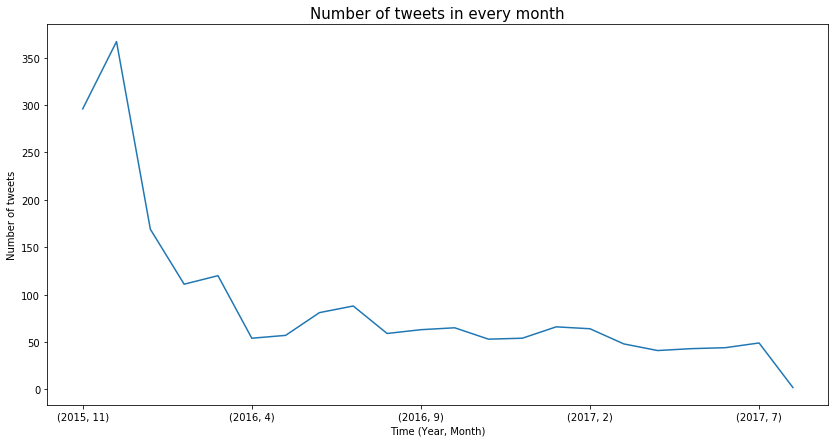

In [83]:
picked_data = df['tweet_id'].groupby([df['timestamp'].dt.year, df['timestamp'].dt.month]).count()
picked_data.plot(kind = 'line')
plt.title('Number of tweets in every month', size = 15)
plt.xlabel('Time (Year, Month)')
plt.ylabel('Number of tweets')
plt.savefig('number_of_tweets_every_month')

#### As you can see, December 2015 has the most of tweets. After that period, number tweets decreased drastically. It carried on decreasing till July 2017.

### The most used tool?

In [79]:
df.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

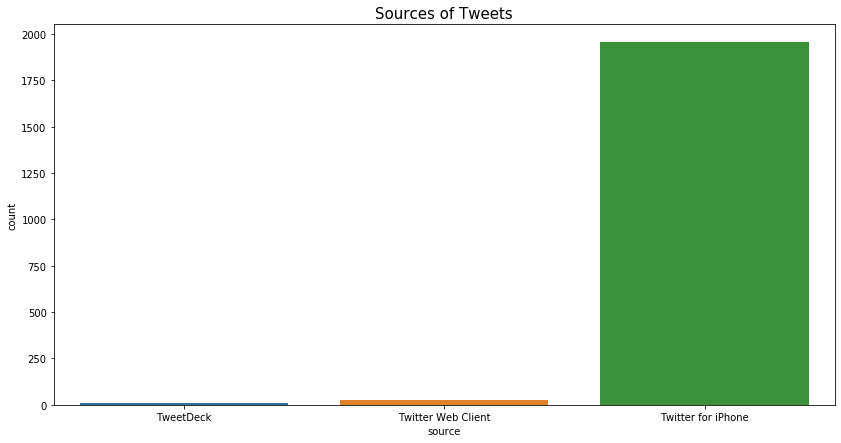

In [84]:
sns.countplot(data=df, x='source')
plt.title('Sources of Tweets', size=15)
plt.savefig('most_used_source_of_tweets')

#### Apparently, the most used source is Iphone. Second and third places are for Twitter Web Client and TweetDeck respectively.

### How many dogs have ratings which are over than 10?

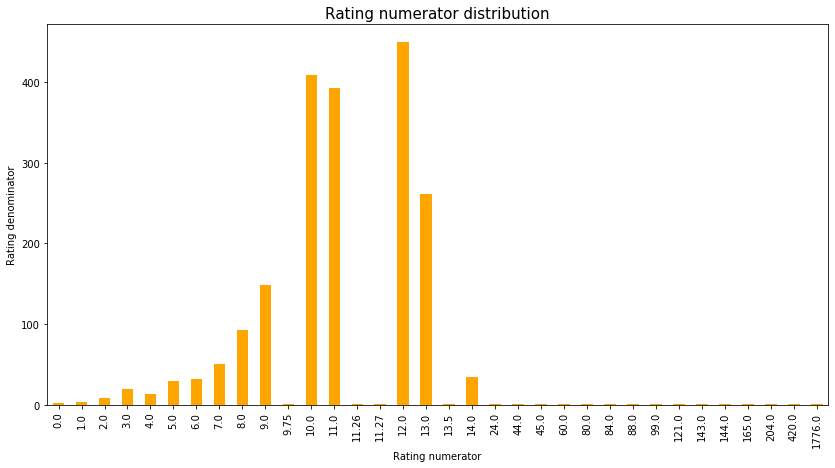

In [100]:
df.rating_numerator_n.value_counts().sort_index().plot(kind = 'bar', color = 'orange')
plt.title('Rating numerator distribution', size = 15)
plt.xlabel('Rating numerator')
plt.ylabel('Rating denominator')
plt.savefig('rating_numerator_distribution')

In [89]:
#Selecting ratings which are over than 10
round(df.rating_numerator_n[df.rating_numerator_n > 10]).count()

1156

#### 1156 dogs have ratings which are over than 10.

## What are the popular dog breeds?

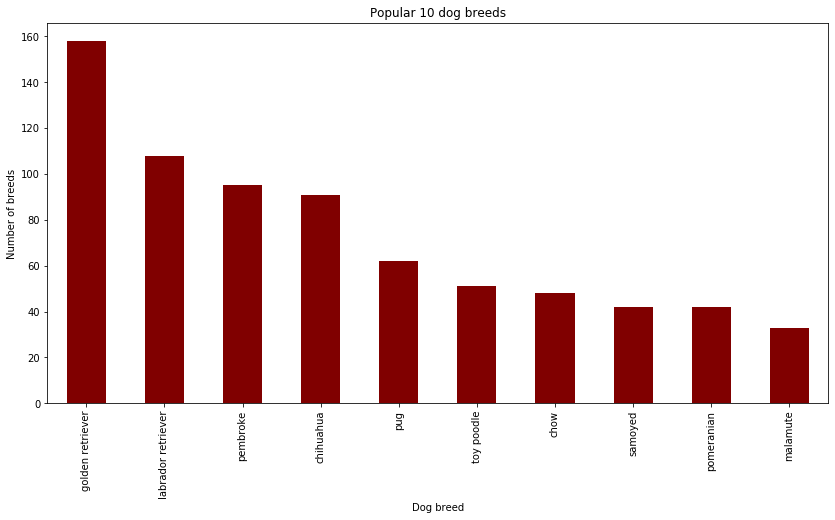

In [95]:
df.dog_breed.value_counts()[0:10].sort_values(ascending = False).plot(kind= 'bar', color = 'maroon')
plt.ylabel('Number of breeds')
plt.xlabel('Dog breed')
plt.title('Popular 10 dog breeds')
plt.savefig('top_dog_breeds')

#### Golden retriever is the most popular breed. Whereas malamute is the least.

## The most popular dog names?

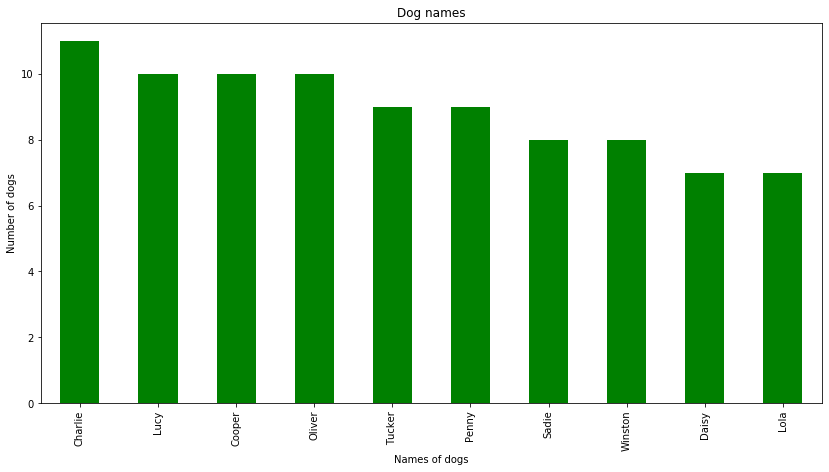

In [98]:
df.name.value_counts()[0:10].sort_values(ascending = False).plot(kind = 'bar', color = 'green')
plt.ylabel('Number of dogs')
plt.xlabel('Names of dogs')
plt.title('Dog names')
plt.savefig('popular_dog_names')

#### Charlie is the most popular name. Meanwhile Lucy, Cooper, Oliver and Tucker are also famous.

## The most frequent dog stage?

In [101]:
df.dog_type.value_counts()

pupper     223
doggo       72
puppo       28
floofer      3
Name: dog_type, dtype: int64

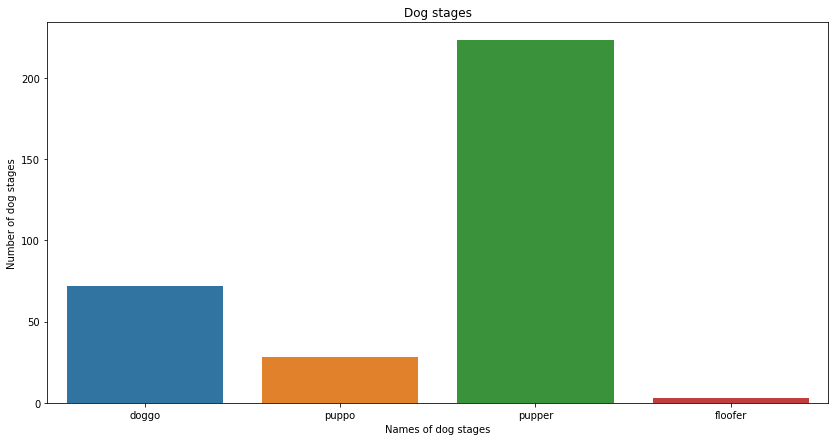

In [102]:
sns.countplot(data=df, x='dog_type')
plt.ylabel('Number of dog stages')
plt.xlabel('Names of dog stages')
plt.title('Dog stages')
plt.savefig('frequent_dog_stages')

#### Pupper is the most frequent one with 223. Whereas doggo, puppo and floofer are 72, 28 and 3 respectively.

## Reference:

https://stackoverflow.com/questions/8689184/nameerror-name-reduce-is-not-defined-in-python
https://classroom.udacity.com/nanodegrees/nd002-ent/parts/f55ce890-c08c-46a5-b57f-55a06c1cc6ae/modules/a8fcd18c-b9a5-4852-a7ec-6dbb08ebfe5a/lessons/a8085857-3e28-4fc7-aeb8-da64ccbc2e20/concepts/d7e3de1b-d7a1-4ebc-9d58-beba021a7c29
https://stackoverflow.com/questions/54343378/pandas-valueerror-pattern-contains-no-capture-groups
https://stackoverflow.com/questions/40353079/pandas-how-to-check-dtype-for-all-columns-in-a-dataframe
https://stackoverflow.com/questions/38294852/making-a-chart-bigger-in-size